<a href="https://colab.research.google.com/github/DoItSon/playdata/blob/main/%EC%98%A4%EC%9D%BCbase_%EC%A0%84%EC%B2%98%EB%A6%AC(%EC%A0%95%EB%A6%AC%EB%B3%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이콘 베이스 라인 지금 전처리 = 0.5763416859

- xc1에서 밑에 코드 적용시켜보기

In [ ]:
# mode_cols = ['U25', 'U20','U14']
# for i in mode_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)
# # mode = [0.57205]
# # mean = [0.57316]
# mode_cols = ['U4', 'U6']
# for i in mode_cols:
#     mode = train[i].mode()
#     train[i] = train[i].fillna(mode)
# # mean = [0.56537]
# # mode = [0.57567]
# # [0.57811]

In [624]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [625]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [626]:
DATA_PATH = "/content/drive/MyDrive/"

In [627]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')

In [628]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

In [629]:
cols = train.columns

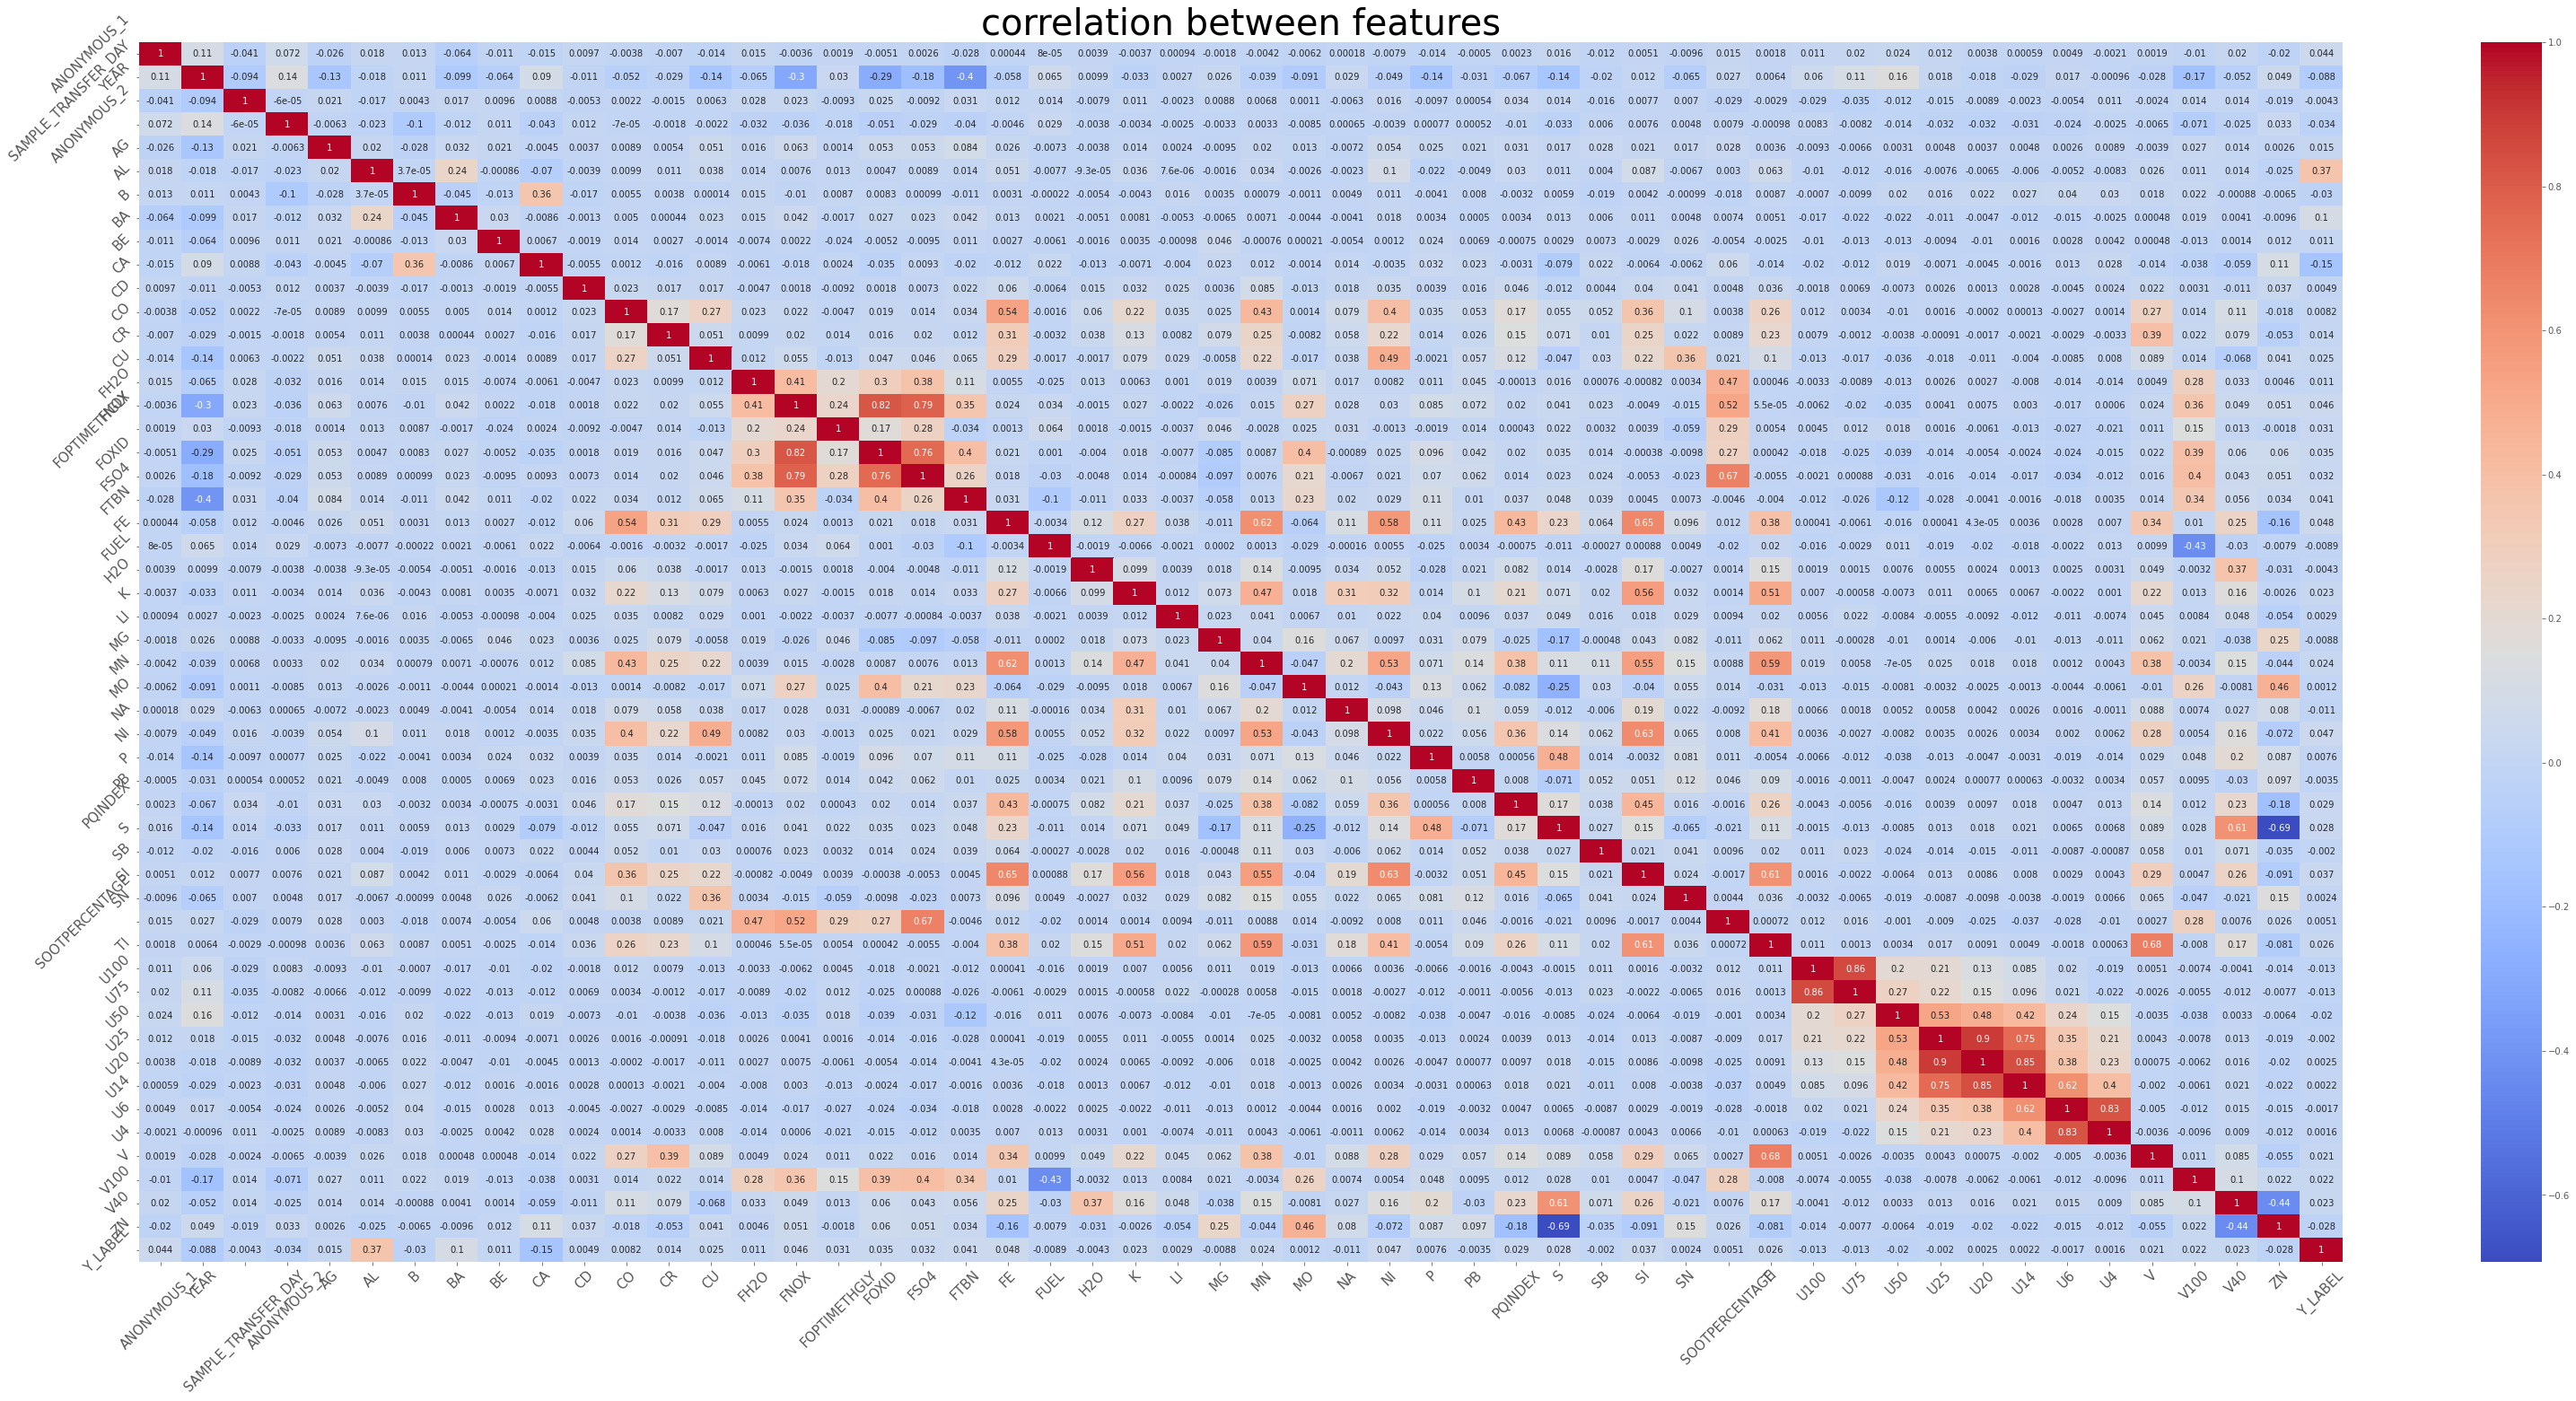

In [653]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(55,25))

heat_table = train[cols].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)
plt.title('correlation between features', fontsize=40)
plt.show()

## 상관관계 해석
- Y_LABEL은 AL (0.37) 
- AL은 BA (0.24)
- 추후에 AL과 BA을 곱해서 피처 추가 해보기!

# 데이터 해석

In [631]:
train.sort_values(by=["COMPONENT_ARBITRARY"])

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
7047,TRAIN_07047,COMPONENT1,1712,2014,6,200,0,5,7,2,...,NaN,NaN,NaN,NaN,NaN,0,13.3,92.8,1228,0
3262,TRAIN_03262,COMPONENT1,1373,2022,2,402,0,8,62,0,...,NaN,NaN,NaN,NaN,NaN,0,12.8,97.6,813,0
8734,TRAIN_08734,COMPONENT1,9526,2018,6,375,0,2,7,0,...,NaN,NaN,NaN,NaN,NaN,0,13.8,98.5,1036,0
8733,TRAIN_08733,COMPONENT1,2611,2009,7,200,0,3,30,0,...,NaN,NaN,NaN,NaN,NaN,0,14.1,106.7,1465,0
8730,TRAIN_08730,COMPONENT1,1715,2022,1,469,0,3,9,0,...,NaN,NaN,NaN,NaN,NaN,0,13.8,105.4,1086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,TRAIN_12430,COMPONENT4,2494,2014,7,200,0,2,6,3,...,NaN,NaN,NaN,NaN,NaN,0,NaN,38.4,9,0
10232,TRAIN_10232,COMPONENT4,1345,2012,2,200,0,7,145,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,75.9,1156,0
11339,TRAIN_11339,COMPONENT4,1156,2013,4,356,0,2,66,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,67.8,826,0
11332,TRAIN_11332,COMPONENT4,5550,2015,6,200,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,68.2,1410,0



- COMPONENT_ARBITRARY를 기준으로 정렬해봤을 때 COMPONENT1의 결측치가 가장 적었다.
- 그래서 COMPONENT1을 이용하여 결측치를 채우기로 결정!

## ANONYMOUS_1와 ANONYMOUS_2, YEAR와 SAMPLE_TRANSFER_DAY, COMPONENT_ARBITRARY를 이용하여 전처리 하기!

In [632]:
# COMPONENT_ARBITRARY, ANONYMOUS_1, YEAR, SAMPLE_TRANSFER_DAY, ANONYMOUS_2

# 결측치 채워 넣기 전

In [633]:
def show(df,col):
    fig,ax = plt.subplots()
    ax.bar(df[col].value_counts().index,df[col].value_counts())
    plt.show()
    print(df[col].value_counts())

In [634]:
fill_mean_func = lambda x: x.fillna(x.mean())
fill_median_func = lambda x: x.fillna(x.median())

In [635]:
train.groupby(["V40"]).mean()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U50,U25,U20,U14,U6,U4,V,V100,ZN,Y_LABEL
V40,,,,,,,,,,,,,,,,,,,,,
2.9,1175.0,2010.0,7.0,375.0,0.0,3.0,3.0,3.0,0.0,2894.0,...,0.0,343.0,1046.0,2813.0,17853.0,26417.0,0.0,NaN,2.0,0.0
3.4,2255.0,2014.5,4.5,200.0,0.0,3.5,239.5,0.0,0.0,1814.0,...,0.0,7.0,10.5,104.0,3785.0,16780.0,0.0,NaN,2.0,0.0
22.8,7790.0,2016.0,5.0,200.0,0.0,2.0,13.0,0.0,0.0,153.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.2,671.0,0.0
28.1,1000.0,2014.0,7.0,200.0,0.0,8.0,77.0,0.0,0.0,3008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,190.0,0.0
28.6,6427.0,2009.0,9.0,200.0,0.0,3.0,331.0,0.0,0.0,2815.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,307.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440.0,1410.0,2014.0,4.0,200.0,0.0,7.0,1.0,2.0,0.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,34.0,0.0
528.9,1940.0,2018.0,4.0,550.0,0.0,2.0,6.0,2.0,0.0,3190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,26.0,0.0
577.9,2087.0,2014.0,5.0,200.0,0.0,2.0,128.0,0.0,0.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,29.0,0.0


### "ANONYMOUS_2", "ANONYMOUS_1"와 "YEAR", "COMPONENT_ARBITRARY"로 분류

In [636]:
zx = train.groupby(["YEAR","COMPONENT_ARBITRARY"]).apply(fill_mean_func)

In [637]:
zx

ID COMPONENT_ARBITRARY  ANONYMOUS_1  \
YEAR COMPONENT_ARBITRARY                                                       
2007 COMPONENT1          237    TRAIN_00237          COMPONENT1         1524   
                         394    TRAIN_00394          COMPONENT1         1350   
                         460    TRAIN_00460          COMPONENT1         2034   
                         735    TRAIN_00735          COMPONENT1         1352   
                         832    TRAIN_00832          COMPONENT1         2034   
...                                     ...                 ...          ...   
2022 COMPONENT4          11980  TRAIN_11980          COMPONENT4         1388   
                         12715  TRAIN_12715          COMPONENT4         4787   
                         13451  TRAIN_13451          COMPONENT4         2420   
                         13656  TRAIN_13656          COMPONENT4         2295   
                         13902  TRAIN_13902          COMPONENT4         1386   

                                YEAR  SAMPLE_TRANSFER_DAY  ANONYMOUS_2  AG  \
YEAR COMPONENT_ARBITRARY                                                     
2007 COMPONENT1          237    2007                    4          200   0   
                         394    2007                    8          550   0   
                         460    2007                    6          550   0   
                         735    2007                    6          550   0   
                         832    2007                    6          550   0   
...                              ...                  ...          ...  ..   
2022 COMPONENT4          11980  2022                    2          588   0   
                         12715  2022                    1         1013   0   
                         13451  2022                    2          564   0   
                         13656  2022                    4          643   0   
                         13902  2022                    5          586   0   

                                AL    B  BA  ...  U25  U20  U14  U6  U4  V  \
YEAR COMPONENT_ARBITRARY                     ...                             
2007 COMPONENT1          237     5  116   0  ...  NaN  NaN  NaN NaN NaN  0   
                         394     2    6   3  ...  NaN  NaN  NaN NaN NaN  0   
                         460     1    1   1  ...  NaN  NaN  NaN NaN NaN  0   
                         735     2   93   4  ...  NaN  NaN  NaN NaN NaN  0   
                         832     3    0   1  ...  NaN  NaN  NaN NaN NaN  0   
...                             ..  ...  ..  ...  ...  ...  ...  ..  .. ..   
2022 COMPONENT4          11980   1    1   0  ...  NaN  NaN  NaN NaN NaN  0   
                         12715   2   13   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13451   3   77   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13656   1   11   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13902   1    0   0  ...  NaN  NaN  NaN NaN NaN  0   

                                    V100    V40    ZN  Y_LABEL  
YEAR COMPONENT_ARBITRARY                                        
2007 COMPONENT1          237    12.80000   95.7  1384        0  
                         394    12.90000  100.2  1390        1  
                         460    13.40000   98.1  1099        0  
                         735    13.40000   99.3  1018        0  
                         832    13.71194  118.9  1296        0  
...                                  ...    ...   ...      ...  
2022 COMPONENT4          11980       NaN   58.8  1058        0  
                         12715       NaN   77.1  1157        0  
                         13451       NaN   74.0   920        0  
                         13656       NaN   68.0   845        0  
                         13902       NaN   58.9  1136        0  

[14095 rows x 54 columns]

In [638]:
zx = train.groupby(["SAMPLE_TRANSFER_DAY","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
# zx = train.groupby(["SAMPLE_TRANSFER_DAY","YEAR"]).apply(fill_mean_func)
# zx = train.groupby(["SAMPLE_TRANSFER_DAY","YEAR"]).apply(fill_mean_func)

In [639]:
xc = zx.groupby(["ANONYMOUS_2","YEAR"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_2","ANONYMOUS_1"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_1","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_2","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
xc

ID  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                      
0                   COMPONENT1          1752   TRAIN_01752   
                                        5481   TRAIN_05481   
                                        6858   TRAIN_06858   
                                        7634   TRAIN_07634   
                                        10143  TRAIN_10143   
...                                                    ...   
203                 COMPONENT1          9331   TRAIN_09331   
216                 COMPONENT3          10422  TRAIN_10422   
245                 COMPONENT3          4111   TRAIN_04111   
246                 COMPONENT3          11857  TRAIN_11857   
368                 COMPONENT1          5978   TRAIN_05978   

                                              COMPONENT_ARBITRARY  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                             
0                   COMPONENT1          1752           COMPONENT1   
                                        5481           COMPONENT1   
                                        6858           COMPONENT1   
                                        7634           COMPONENT1   
                                        10143          COMPONENT1   
...                                                           ...   
203                 COMPONENT1          9331           COMPONENT1   
216                 COMPONENT3          10422          COMPONENT3   
245                 COMPONENT3          4111           COMPONENT3   
246                 COMPONENT3          11857          COMPONENT3   
368                 COMPONENT1          5978           COMPONENT1   

                                               ANONYMOUS_1  YEAR  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                            
0                   COMPONENT1          1752          4376  2020   
                                        5481          1157  2021   
                                        6858          2118  2010   
                                        7634          3511  2021   
                                        10143         2701  2019   
...                                                    ...   ...   
203                 COMPONENT1          9331          1000  2009   
216                 COMPONENT3          10422         3750  2015   
245                 COMPONENT3          4111          4093  2015   
246                 COMPONENT3          11857         4093  2015   
368                 COMPONENT1          5978          8242  2015   

                                               SAMPLE_TRANSFER_DAY  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                              
0                   COMPONENT1          1752                     0   
                                        5481                     0   
                                        6858                     0   
                                        7634                     0   
                                        10143                    0   
...                                                            ...   
203                 COMPONENT1          9331                   203   
216                 COMPONENT3          10422                  216   
245                 COMPONENT3          4111                   245   
246                 COMPONENT3          11857                  246   
368                 COMPONENT1          5978                   368   

                                               ANONYMOUS_2  AG  AL    B  BA  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                                       
0                   COMPONENT1          1752           417   0   3    5   0   
                                        5481           357   0   3  178   0   
                                        6858           200   0   3  180   0   
                                        7634           200   0   0    0   0   
                                        10143          200   0   5  122   0   
..

In [640]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [641]:
features = feat.merge(xc,how="left",on="ID")
train = features

In [642]:
xc1 = train.groupby(["ANONYMOUS_2"]).apply(fill_mean_func)
xc1 # xc1에서 점수가 떨어짐 (정규분포는 상향 평준화)

ID COMPONENT_ARBITRARY  ANONYMOUS_1  YEAR  \
ANONYMOUS_2                                                             
200         0      TRAIN_00000          COMPONENT3         1486  2011   
            2      TRAIN_00002          COMPONENT2         2415  2015   
            3      TRAIN_00003          COMPONENT3         7389  2010   
            4      TRAIN_00004          COMPONENT3         3954  2015   
            8      TRAIN_00008          COMPONENT3         4880  2014   
...                        ...                 ...          ...   ...   
8250        12592  TRAIN_12592          COMPONENT1         9146  2018   
9650        1881   TRAIN_01881          COMPONENT1        10590  2018   
            2506   TRAIN_02506          COMPONENT1        10590  2018   
            3181   TRAIN_03181          COMPONENT3        10590  2018   
            9406   TRAIN_09406          COMPONENT1        10590  2018   

                   SAMPLE_TRANSFER_DAY  ANONYMOUS_2  AG   AL    B  BA  ...  \
ANONYMOUS_2                                                            ...   
200         0                        7          200   0    3   93   0  ...   
            2                        2          200   0  110    1   1  ...   
            3                        2          200   0    8    3   0  ...   
            4                        4          200   0    1  157   0  ...   
            8                        7          200   0    0    1   0  ...   
...                                ...          ...  ..  ...  ...  ..  ...   
8250        12592                    7         8250   0    4    0   0  ...   
9650        1881                     2         9650   0    0    0   0  ...   
            2506                     2         9650   0    3    4   0  ...   
            3181                     2         9650   0    0    2   0  ...   
            9406                     2         9650   0    0    2   0  ...   

                         U25        U20         U14            U6  \
ANONYMOUS_2                                                         
200         0      25.483221  65.657718  265.222841   5615.019189   
            2       0.000000   3.000000   39.000000  11261.000000   
            3      29.981818  54.309091  198.483886   5428.819382   
            4      33.865497  60.409357  279.640746   5935.617038   
            8      28.328358  48.845771  180.144224   3959.977286   
...                      ...        ...         ...           ...   
8250        12592        NaN        NaN         NaN           NaN   
9650        1881         NaN        NaN         NaN           NaN   
            2506         NaN        NaN         NaN           NaN   
            3181         NaN        NaN         NaN           NaN   
            9406         NaN        NaN         NaN           NaN   

                             U4  V       V100    V40    ZN  Y_LABEL  
ANONYMOUS_2                                                          
200         0      18599.617449  0  13.639260  154.0    75        0  
            2      41081.000000  0  13.613313   72.6   412        1  
            3      19571.831588  0  13.907224  133.3     7        0  
            4      22551.584953  0  13.613313  133.1   128        0  
            8      13717.972987  0  13.585227  140.7    89        0  
...                         ... ..        ...    ...   ...      ...  
8250        12592           NaN  0  13.700000  108.9  1199        0  
9650        1881            NaN  0  14.400000  110.2  1154        0  
            2506            NaN  0  13.400000   99.4  1044        0  
            3181            NaN  0  13.666667  142.1    78        0  
            9406            NaN  0  13.200000   95.1  1060        0  

[14095 rows x 54 columns]

In [643]:
xc2 = xc1.groupby(["V40"]).apply(fill_mean_func)
xc2 # 점수 떨어짐

ID COMPONENT_ARBITRARY  ANONYMOUS_1  YEAR  \
ANONYMOUS_2                                                             
200         0      TRAIN_00000          COMPONENT3         1486  2011   
            2      TRAIN_00002          COMPONENT2         2415  2015   
            3      TRAIN_00003          COMPONENT3         7389  2010   
            4      TRAIN_00004          COMPONENT3         3954  2015   
            8      TRAIN_00008          COMPONENT3         4880  2014   
...                        ...                 ...          ...   ...   
8250        12592  TRAIN_12592          COMPONENT1         9146  2018   
9650        1881   TRAIN_01881          COMPONENT1        10590  2018   
            2506   TRAIN_02506          COMPONENT1        10590  2018   
            3181   TRAIN_03181          COMPONENT3        10590  2018   
            9406   TRAIN_09406          COMPONENT1        10590  2018   

                   SAMPLE_TRANSFER_DAY  ANONYMOUS_2  AG   AL    B  BA  ...  \
ANONYMOUS_2                                                            ...   
200         0                        7          200   0    3   93   0  ...   
            2                        2          200   0  110    1   1  ...   
            3                        2          200   0    8    3   0  ...   
            4                        4          200   0    1  157   0  ...   
            8                        7          200   0    0    1   0  ...   
...                                ...          ...  ..  ...  ...  ..  ...   
8250        12592                    7         8250   0    4    0   0  ...   
9650        1881                     2         9650   0    0    0   0  ...   
            2506                     2         9650   0    3    4   0  ...   
            3181                     2         9650   0    0    2   0  ...   
            9406                     2         9650   0    0    2   0  ...   

                         U25        U20         U14            U6  \
ANONYMOUS_2                                                         
200         0      25.483221  65.657718  265.222841   5615.019189   
            2       0.000000   3.000000   39.000000  11261.000000   
            3      29.981818  54.309091  198.483886   5428.819382   
            4      33.865497  60.409357  279.640746   5935.617038   
            8      28.328358  48.845771  180.144224   3959.977286   
...                      ...        ...         ...           ...   
8250        12592  31.507661  59.806099  252.029190   5070.819996   
9650        1881   27.240211  52.708562  267.507629   6070.731033   
            2506   33.858390  55.490698  222.786439   5861.438347   
            3181   23.916731  43.763661  176.141719   4997.910636   
            9406   23.394947  44.598075  191.977743   4197.866985   

                             U4  V       V100    V40    ZN  Y_LABEL  
ANONYMOUS_2                                                          
200         0      18599.617449  0  13.639260  154.0    75        0  
            2      41081.000000  0  13.613313   72.6   412        1  
            3      19571.831588  0  13.907224  133.3     7        0  
            4      22551.584953  0  13.613313  133.1   128        0  
            8      13717.972987  0  13.585227  140.7    89        0  
...                         ... ..        ...    ...   ...      ...  
8250        12592  15455.428938  0  13.700000  108.9  1199        0  
9650        1881   18857.327562  0  14.400000  110.2  1154        0  
            2506   18861.786829  0  13.400000   99.4  1044        0  
            3181   21244.491961  0  13.666667  142.1    78        0  
            9406   16753.762299  0  13.200000   95.1  1060        0  

[14095 rows x 54 columns]

In [644]:
xc2.isnull().sum()

ID                      0
COMPONENT_ARBITRARY     0
ANONYMOUS_1             0
YEAR                    0
SAMPLE_TRANSFER_DAY     0
ANONYMOUS_2             0
AG                      0
AL                      0
B                       0
BA                      0
BE                      0
CA                      0
CD                      0
CO                      0
CR                      0
CU                      0
FH2O                   21
FNOX                   21
FOPTIMETHGLY           21
FOXID                  21
FSO4                   21
FTBN                   21
FE                      0
FUEL                   21
H2O                     0
K                       0
LI                      0
MG                      0
MN                      0
MO                      0
NA                      0
NI                      0
P                       0
PB                      0
PQINDEX                 0
S                       0
SB                      0
SI                      0
SN          

In [645]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,25.483221,65.657718,265.222841,5615.019189,18599.617449,0,13.639260,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.300000,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.613313,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,29.981818,54.309091,198.483886,5428.819382,19571.831588,0,13.907224,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,33.865497,60.409357,279.640746,5935.617038,22551.584953,0,13.613313,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,28.328358,48.845771,180.144224,3959.977286,13717.972987,0,13.585227,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,27.491892,44.908108,201.577815,3898.352917,13537.118569,0,14.500000,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,12.450000,24.025000,119.545730,2881.378482,16448.336158,0,13.871036,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.437500,44.3,652,0


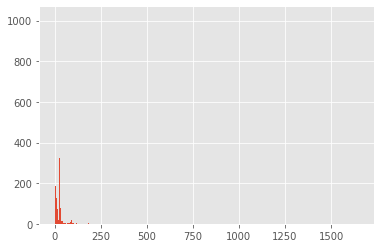

28.328358      1019
27.491892       866
25.483221       798
33.865497       766
41.907143       763
               ... 
181.000000        1
141.000000        1
106.000000        1
246.000000        1
1073.000000       1
Name: U25, Length: 316, dtype: int64


In [654]:
show(xc1,"U25")  # U25,U20,U14/U6,U4 => 0으로 채우기!
# FNOX는 FOXID,FSO4

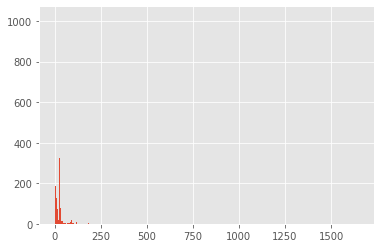

28.328358      1021
27.491892       867
25.483221       800
33.865497       766
41.907143       763
               ... 
23.574889         1
18.616260         1
27.181533         1
155.000000        1
1163.000000       1
Name: U25, Length: 972, dtype: int64


In [657]:
show(xc2,"U25")  # U25,U20,U14/U6,U4 => 0으로 채우기!

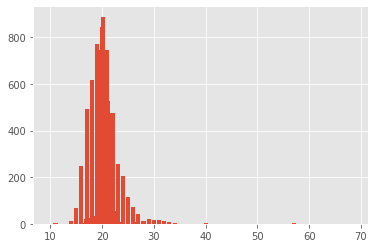

20.204819    888
20.000000    842
19.000000    771
19.756579    747
21.000000    744
            ... 
13.000000      1
20.444444      1
24.333333      1
53.000000      1
37.000000      1
Name: FSO4, Length: 145, dtype: int64


In [648]:
show(xc1,"FSO4")

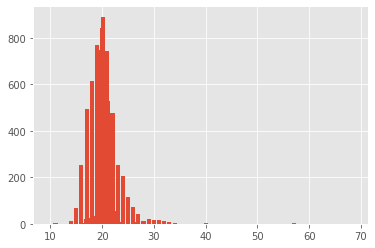

20.204819    891
20.000000    844
19.000000    771
19.756579    748
21.000000    744
            ... 
20.024067      1
20.273521      1
20.222972      1
20.175492      1
19.937434      1
Name: FSO4, Length: 597, dtype: int64


In [649]:
show(xc2,"FSO4")  # U25,U20,U14/U6,U4 => 0으로 채우기

In [650]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [651]:
features = feat.merge(xc2,how="left",on="ID")
train = features

In [562]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,25.483221,65.657718,265.222841,5615.019189,18599.617449,0,13.639260,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.300000,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.613313,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,29.981818,54.309091,198.483886,5428.819382,19571.831588,0,13.907224,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,33.865497,60.409357,279.640746,5935.617038,22551.584953,0,13.613313,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,28.328358,48.845771,180.144224,3959.977286,13717.972987,0,13.585227,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,27.491892,44.908108,201.577815,3898.352917,13537.118569,0,14.500000,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,12.450000,24.025000,119.545730,2881.378482,16448.336158,0,13.871036,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.437500,44.3,652,0


In [563]:
# cols = ["FH2O","FNOX","FOPTIMETHGLY","FOXID","FSO4","FTBN","FUEL","SOOTPERCENTAGE","U100","U75","U50","U25","U20","U14","CD","U6","U4","V100"]

In [656]:
train.isnull().sum()

ID                      0
COMPONENT_ARBITRARY     0
ANONYMOUS_1             0
YEAR                    0
SAMPLE_TRANSFER_DAY     0
ANONYMOUS_2             0
AG                      0
AL                      0
B                       0
BA                      0
BE                      0
CA                      0
CD                      0
CO                      0
CR                      0
CU                      0
FH2O                   21
FNOX                   21
FOPTIMETHGLY           21
FOXID                  21
FSO4                   21
FTBN                   21
FE                      0
FUEL                   21
H2O                     0
K                       0
LI                      0
MG                      0
MN                      0
MO                      0
NA                      0
NI                      0
P                       0
PB                      0
PQINDEX                 0
S                       0
SB                      0
SI                      0
SN          

In [565]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,25.483221,65.657718,265.222841,5615.019189,18599.617449,0,13.639260,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.300000,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.613313,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,29.981818,54.309091,198.483886,5428.819382,19571.831588,0,13.907224,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,33.865497,60.409357,279.640746,5935.617038,22551.584953,0,13.613313,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,28.328358,48.845771,180.144224,3959.977286,13717.972987,0,13.585227,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,27.491892,44.908108,201.577815,3898.352917,13537.118569,0,14.500000,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,12.450000,24.025000,119.545730,2881.378482,16448.336158,0,13.871036,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.437500,44.3,652,0


## 해석


In [566]:
# mode_cols = ["CD"]  # CD는 이상치가 있어서 median 사용!
# for i in mode_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)

In [567]:
# # V40,V100은 상관관계가 높으므로 0을 넣음!
# mode = train["V40"].median()
# train[i] = train[i].fillna(mode)

In [568]:
# mode = train["V100"].mean()
# train[i] = train[i].fillna(mode)

In [569]:
train.isnull().sum().sum()

413

# 결측치 채우기!

In [570]:
# FNOX, FOXID,FSO4   mean으로 채우기
# U75, U100 0으로 채우기!
# U25, U20,U14, (U14=0.64) 최빈값으로 채우기
# U6는 U4 (mean or median)
# 나머지 결측치는 0으로 채우기!

In [571]:
mode_cols = ["FNOX", "FOXID","FSO4" ]
for i in mode_cols:
    mode = train[i].median()
    train[i] = train[i].fillna(mode)

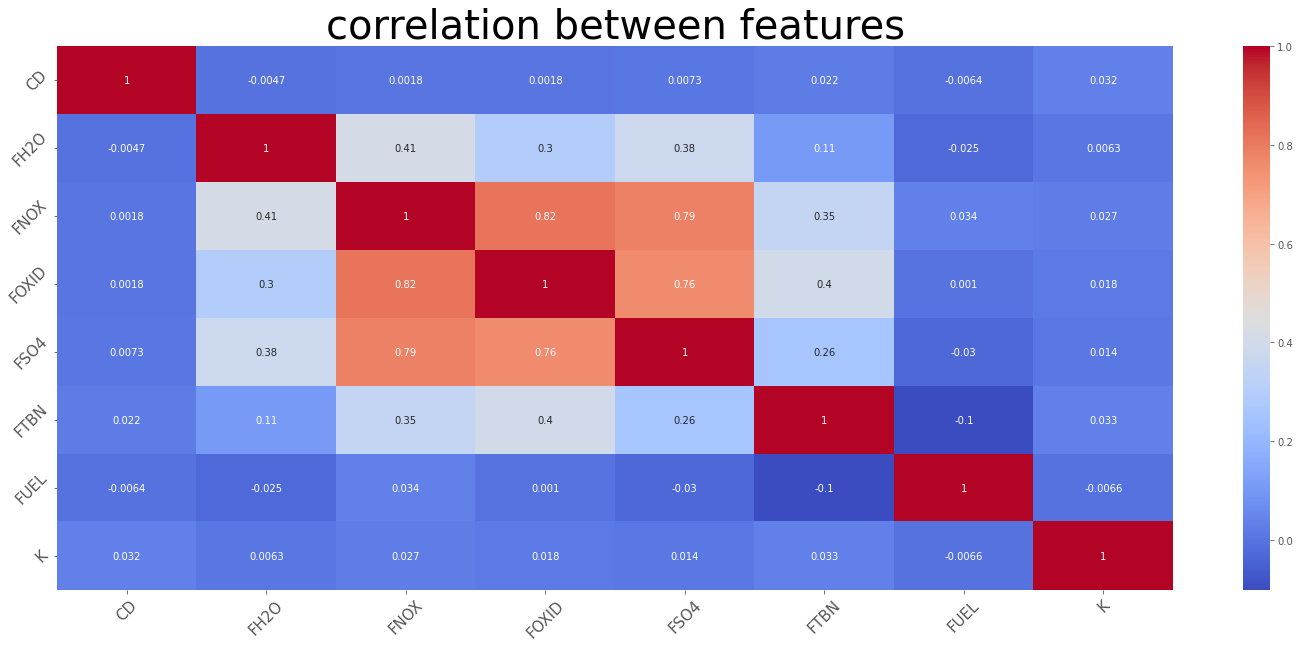

In [572]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(25,10))

heat_table = train[['CD', 'FH2O', 'FNOX', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K']].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)

plt.title('correlation between features', fontsize=40)
plt.show()

In [573]:
# 떨어진 상관관계 리스트
# cd,ftbn/cd,fuel/cd,k 
# k,ftbm / k,fuel
# fuel,fh2o

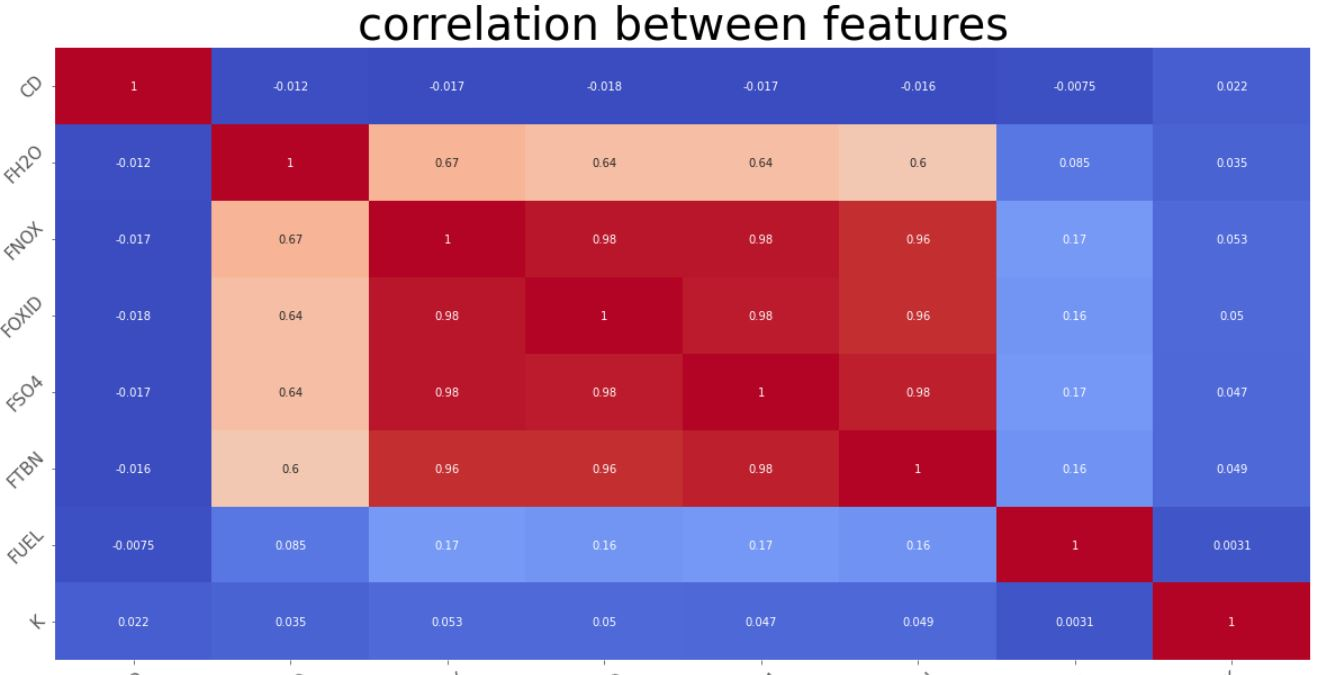

In [574]:
# median_cols = ["U25","U20","U14","U6","U4"]
# for i in median_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)

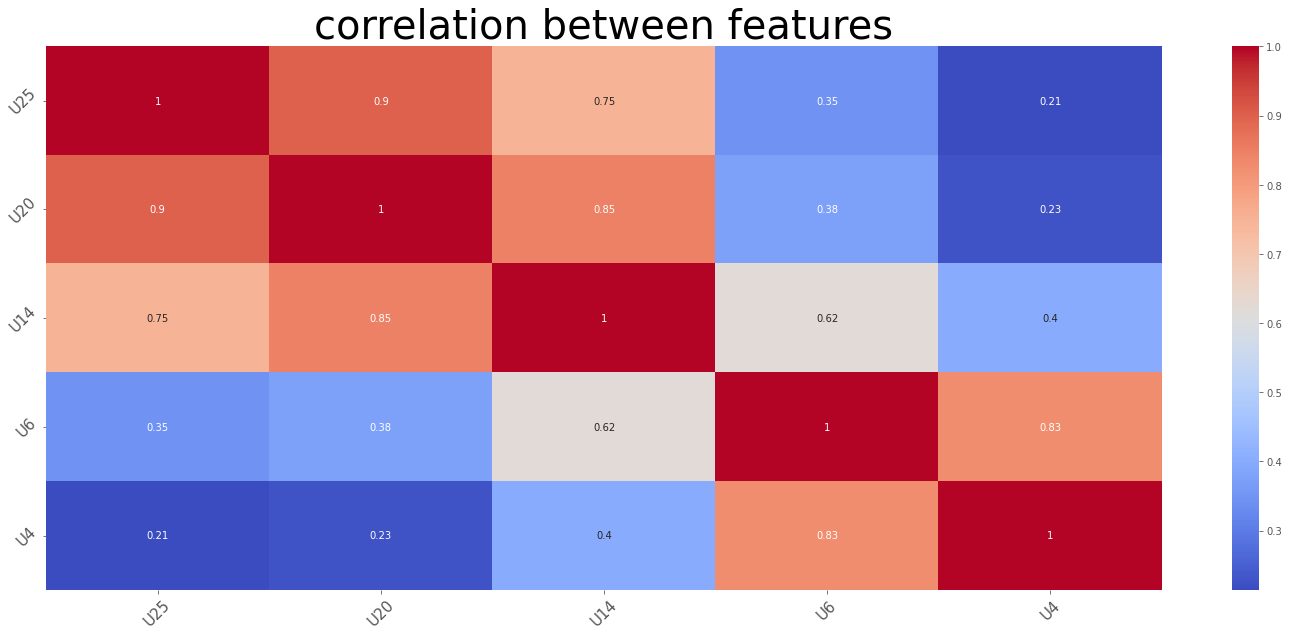

In [575]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(25,10))

heat_table = train[["U25","U20","U14","U6","U4"]].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)

plt.title('correlation between features', fontsize=40)
plt.show()

In [576]:
#  "FH2O","FNOX","FOXID","FSO4","FTBN","SOOTPERCENTAGE","U25","U20","U14","U6","U4","V100" 평균으로 채우기

In [577]:
# 'CD','FOPTIMETHGLY',"FUEL",'K','U100','U75','U50' 는 최빈값 or 0으로 채우기 (정정 중앙값으로 채움)

In [578]:
# mode_cols = ['CD','FOPTIMETHGLY',"FUEL",'K','U100','U75','U50']
# for i in mode_cols:
#     mode = train[i].mode()[0]
#     train[i] = train[i].fillna(mode)
# 제일 높음!

In [579]:
train.isnull().sum().sum()

350

In [580]:
# mean_cols = ["FH2O","FNOX","FOXID","FSO4","FTBN","SOOTPERCENTAGE","V100"]
# for i in mean_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)

In [581]:
# median_cols = ["U25","U20","U14","U6","U4"]
# for i in median_cols:
#     mode = train[i].median()
#     train[i] = train[i].fillna(mode)

In [582]:
train.isnull().sum().sum()

350

In [583]:
# mask = train["U25"].isin([1654])
# y = train.loc[mask]
# y # 4부터 시작 최빈값으로 채우기 CD, FOPTIMETHGLY,FUEL,K

- 전처리

In [584]:
# x = train.isnull().sum().reset_index()
# cols = list(x["index"])
# mask = x[0]!=0
# x1 = x.loc[mask]
# cols=list(x1["index"])
# cols

In [585]:
# from sklearn.impute import SimpleImputer

# for i in cols:
#     imputer = SimpleImputer(strategy="most_frequent")
#     train[i] = imputer.fit_transform(train[[i]])

In [586]:
# from sklearn.impute import KNNImputer
# for i in cols:
#     imputer = KNNImputer(n_neighbors=13,weights="distance")
#     train[i] = imputer.fit_transform(train[[i]])

In [587]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [588]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [589]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,25.483221,65.657718,265.222841,5615.019189,18599.617449,0,13.639260,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.300000,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.613313,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,29.981818,54.309091,198.483886,5428.819382,19571.831588,0,13.907224,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,33.865497,60.409357,279.640746,5935.617038,22551.584953,0,13.613313,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,28.328358,48.845771,180.144224,3959.977286,13717.972987,0,13.585227,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,27.491892,44.908108,201.577815,3898.352917,13537.118569,0,14.500000,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,12.450000,24.025000,119.545730,2881.378482,16448.336158,0,13.871036,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.437500,44.3,652,0


In [590]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [591]:
features = feat.merge(xc,how="left",on="ID")

In [592]:
train = features

In [593]:
train = train.fillna(0)
test = test.fillna(0)

In [594]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [595]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((11276, 52), (2819, 52), (11276,), (2819,))

In [596]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))

le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [597]:
train_X

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
822,2,0.018731,4,-0.051286,-0.356161,-0.150219,-0.119547,-0.186532,-0.225981,-0.042285,...,-0.209192,-0.012455,0.194256,0.182182,0.142801,0.132404,-0.107095,0.388290,0.678413,-1.097000
6794,1,0.671873,6,-0.475757,-0.356161,-0.150219,-0.141100,-0.633402,-0.225981,-0.042285,...,-0.249081,-0.091055,-0.020270,0.007196,0.057796,0.219095,-0.107095,0.389334,-1.211150,-0.081955
12200,2,-0.464419,7,0.033608,-0.356161,-0.150219,-0.097994,-0.603611,1.053536,-0.042285,...,0.038862,0.051746,0.000953,-0.080210,-0.081017,-0.113368,-0.107095,0.376511,0.447358,-0.948227
10326,2,-0.250266,4,-0.221075,0.379399,-0.150219,-0.119547,-0.613541,0.733657,-0.042285,...,-0.306785,-0.587489,-0.560674,-0.635794,-0.616540,-0.804014,-0.107095,-2.585042,1.516479,-1.031088
319,2,-0.246705,9,0.203397,-0.356161,-0.150219,-0.097994,4.450985,-0.225981,-0.042285,...,1.167473,0.488176,0.519961,0.534474,0.460202,0.389096,-0.107095,0.359475,0.602048,-0.219428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,1,0.186587,5,0.542974,-0.356161,-0.150219,-0.130324,-0.524167,-0.225981,-0.042285,...,-0.249081,0.811554,0.715599,1.220839,0.193511,0.037319,-0.107095,0.394412,-1.283600,0.064935
6763,2,0.727667,9,0.458080,-0.356161,-0.150219,-0.141100,-0.633402,-0.225981,-0.042285,...,1.167473,0.488176,0.519961,0.534474,0.460202,0.389096,-0.107095,0.359475,0.674497,-0.904914
5944,0,-0.173580,6,-0.305969,-0.356161,-0.150219,-0.033334,0.717138,-0.225981,-0.042285,...,-0.105914,0.032871,-0.044322,-0.014106,-0.089350,-0.122473,-0.107095,0.314332,-0.265389,1.409541
9952,2,-0.339062,3,-0.475757,0.001940,-0.150219,-0.108771,-0.603611,-0.225981,-0.042285,...,-0.306785,-0.587489,-0.560674,-0.635794,-0.616540,-0.804014,-0.107095,-2.585042,-0.171401,0.260788


In [598]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y


In [599]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [600]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [601]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=52, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [602]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)

        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [603]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [604]:
model = Teacher()
model.eval()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.26219] Val Loss : [0.32428] Val F1 Score : [0.77494]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.19255] Val Loss : [0.28887] Val F1 Score : [0.77501]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.18768] Val Loss : [0.25485] Val F1 Score : [0.78976]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.18930] Val Loss : [0.31585] Val F1 Score : [0.78020]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.17016] Val Loss : [0.29997] Val F1 Score : [0.79631]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.16952] Val Loss : [0.33938] Val F1 Score : [0.78850]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.16096] Val Loss : [0.26822] Val F1 Score : [0.79536]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.14607] Val Loss : [0.25927] Val F1 Score : [0.78850]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.14117] Val Loss : [0.36884] Val F1 Score : [0.78877]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.13753] Val Loss : [0.32075] Val F1 Score : [0.79518]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14700] Val Loss : [0.30133] Val F1 Score : [0.79367]
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.12706] Val Loss : [0.31606] Val F1 Score : [0.78443]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.12534] Val Loss : [0.34599] Val F1 Score : [0.78682]
Epoch 00013: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.11776] Val Loss : [0.33770] Val F1 Score : [0.78572]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.11662] Val Loss : [0.33541] Val F1 Score : [0.79032]
Epoch 00015: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.11830] Val Loss : [0.34264] Val F1 Score : [0.78554]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.12252] Val Loss : [0.36062] Val F1 Score : [0.79212]
Epoch 00017: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.11308] Val Loss : [0.35402] Val F1 Score : [0.79087]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.11290] Val Loss : [0.33784] Val F1 Score : [0.78839]
Epoch 00019: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.11149] Val Loss : [0.33896] Val F1 Score : [0.78740]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.11630] Val Loss : [0.35639] Val F1 Score : [0.79801]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.10931] Val Loss : [0.34916] Val F1 Score : [0.79261]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.11319] Val Loss : [0.34102] Val F1 Score : [0.78863]
Epoch 00023: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.12052] Val Loss : [0.35992] Val F1 Score : [0.79117]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.11626] Val Loss : [0.35794] Val F1 Score : [0.78863]
Epoch 00025: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.11368] Val Loss : [0.34098] Val F1 Score : [0.77357]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.10962] Val Loss : [0.33975] Val F1 Score : [0.79032]
Epoch 00027: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.12263] Val Loss : [0.35854] Val F1 Score : [0.78884]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.11213] Val Loss : [0.34531] Val F1 Score : [0.78323]
Epoch 00029: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.11253] Val Loss : [0.33635] Val F1 Score : [0.78884]


In [605]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [606]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [607]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [608]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model


In [609]:

def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [610]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)


In [611]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.AdamW(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.33218] Val Loss : [0.28571] Val F1 Score : [0.47709]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.30183] Val Loss : [0.28898] Val F1 Score : [0.48582]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.29711] Val Loss : [0.28321] Val F1 Score : [0.48950]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.28812] Val Loss : [0.27895] Val F1 Score : [0.50924]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.28565] Val Loss : [0.28150] Val F1 Score : [0.50405]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.28503] Val Loss : [0.28413] Val F1 Score : [0.49946]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.27963] Val Loss : [0.27902] Val F1 Score : [0.50454]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.27908] Val Loss : [0.28252] Val F1 Score : [0.49196]
Epoch 00008: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.27780] Val Loss : [0.28106] Val F1 Score : [0.51056]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.27811] Val Loss : [0.27998] Val F1 Score : [0.51914]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.27782] Val Loss : [0.28036] Val F1 Score : [0.50859]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.27540] Val Loss : [0.27767] Val F1 Score : [0.50702]
Epoch 00012: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.27526] Val Loss : [0.27992] Val F1 Score : [0.51174]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.27799] Val Loss : [0.28122] Val F1 Score : [0.50946]
Epoch 00014: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.27878] Val Loss : [0.28032] Val F1 Score : [0.51287]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.27255] Val Loss : [0.27892] Val F1 Score : [0.51545]
Epoch 00016: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.27925] Val Loss : [0.27944] Val F1 Score : [0.51773]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.27698] Val Loss : [0.27845] Val F1 Score : [0.51152]
Epoch 00018: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.27343] Val Loss : [0.27922] Val F1 Score : [0.51914]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.27025] Val Loss : [0.27871] Val F1 Score : [0.52221]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.27075] Val Loss : [0.27904] Val F1 Score : [0.51767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.27109] Val Loss : [0.28002] Val F1 Score : [0.52119]
Epoch 00022: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.27029] Val Loss : [0.27983] Val F1 Score : [0.51968]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.27243] Val Loss : [0.27953] Val F1 Score : [0.51865]
Epoch 00024: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.27277] Val Loss : [0.28041] Val F1 Score : [0.52040]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.27625] Val Loss : [0.27976] Val F1 Score : [0.51939]
Epoch 00026: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.27650] Val Loss : [0.27987] Val F1 Score : [0.52196]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.27297] Val Loss : [0.28144] Val F1 Score : [0.51816]
Epoch 00028: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.27072] Val Loss : [0.28059] Val F1 Score : [0.52366]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.27306] Val Loss : [0.28229] Val F1 Score : [0.50494]


In [612]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [613]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')
# 0.58403
# [0.57187]
# mean[0.57812]
# 원핫인코딩 = [0.54376]
# lr를 2로 변경 = [0.55327]
# 위에 + standard스케일링 = [0.57166]
# 위에 AdamW = [0.57277] *************
# 에폭 50 = [0.56790]
# line9 + elu = [0.56184]
# line9 + median(결측치) = [0.57021]
# mode = [0.57251]
# mean과 mode =  [0.55979]
# mode + 0 = [0.56870]
# 기존 + GRU = [0.56706]
# 기존 + GRU(ELU) = [0.55696]
# 기존 + LSTM = [0.56892]
# 위에 + 전처리(KNNImputer) = [0.58015]
# 위에 AdamW = [0.57277] + 전처리(KNNImputer) = [0.57171]
# 다시 돌아옴 = [0.57508]
# 결측치 + 다시 돌아옴 = [0.57427]
# 다시 돌아옴 + 내결측치 가설 맞은듯? = [0.57809]
# mask 2개 = [0.56536]
# mask 3개 = [0.58376]
# xc해서 다시보기!
# [0.53884]
# [0.54830]
# 전처리 = [0.55420] => 0.5689680397
# xc2 떨어짐 ㅠㅠ=>[0.54859]

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.54859]


In [619]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [620]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [621]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [622]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [623]:
submit.to_csv('/content/drive/MyDrive/submit.csv', index=False)